In [1]:
import psycopg2
from sqlalchemy import create_engine, Column, Integer, String, Float, ForeignKey
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import relationship, sessionmaker
import re
from __future__ import print_function
import cPickle as pkl
from collections import Counter

In [2]:
import numpy as np
import pandas as pd
import nltk
import re
import os
import codecs
from sklearn import feature_extraction
import mpld3
import pandas as pd
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import f_regression, mutual_info_regression, mutual_info_classif

In [3]:
dbname = 'restaurants'
username = 'andylane'
engine = create_engine('postgres://%s@localhost/%s'%(username,dbname))
print(engine.url)
con = None
con = psycopg2.connect(database = "restaurants", user = "andylane")
Session = sessionmaker(bind=engine)
session = Session()

from menusights_aux import *
recipes = pd.read_sql("recipes", engine)
names = session.query(Recipe)

postgres://andylane@localhost/restaurants


### Define function to make Recipes+Ingredients into vector

In [9]:
    ground_truth_x =[]
    ground_truth_y =[]
    for item in pkl.load(open("groundtruth.pkl", "rb")):
        ground_truth_x.append(str(item["item_name"] + " " + str(item['item_description'])))
        ground_truth_y.append(item["nf_cholesterol"])

    for item in pkl.load(open("groundtruth2.pkl", "rb")):
        ground_truth_x.append(str(unicode(item["item_name"]).encode("utf-8") + " " + str(item['item_description']).encode("utf-8")))
        ground_truth_y.append(item["nf_cholesterol"])

    for item in pkl.load(open("groundtruth3.pkl", "rb")):
        ground_truth_x.append(str(unicode(item["item_name"]).encode("utf-8") + " " + str(item['item_description']).encode("utf-8")))
        ground_truth_y.append(item["nf_cholesterol"])

# Need to put tokenize_and_stem before this
    tokenized_names_ground_truth = [tokenize_and_stem(i.decode("utf-8")) for i in (ground_truth_x)]
    # Puts words from new ground truth set into matrix from training set
    ground_truth_vectorized = vectorizer.transform(tokenized_names_ground_truth)

NameError: name 'tokenize_and_stem' is not defined

In [5]:
unicode(item["item_name"])

u'Fresh Sauteed Zucchini & Squash'

In [6]:
item

{'brand_name': u"Denny's",
 'item_description': u'',
 'item_name': u'Fresh Sauteed Zucchini & Squash',
 'nf_calories': 60,
 'nf_cholesterol': 0,
 'nf_ingredient_statement': u'',
 'nf_sodium': 105}

In [7]:
str(item["item_name"] + " " + "item_description")

'Fresh Sauteed Zucchini & Squash item_description'

In [8]:
def recipes_and_ingredients_to_vector(names=names):
    stopwords = nltk.corpus.stopwords.words('english')
    stemmer = SnowballStemmer("english")

    def tokenize_and_stem(title, is_ingredient = False):
        stemmer = SnowballStemmer("english")
        stemmed_titles = []
        new_title=[]
        for word in nltk.word_tokenize(title):
            new_title.append(stemmer.stem(word))
        stemmed_titles.extend(new_title)
        return " ".join([i for i in stemmed_titles])

    def clean_up_ingredient(ingredient_line):
        ingredient_line = re.sub("\[u\'", "", ingredient_line)
        ingredient_line = re.sub("\']", "", ingredient_line)
        return find_measurement_words(ingredient_line)

    def get_ingredientslist_for_recipeid(i):
        return [clean_up_ingredient(item.ingredient)\
                for item in names.filter(Recipe.id == i).all()[0].ingredients]

    def make_ingredient_list_string(ingredientdictlist):
        return " ".join((str(j["ingredient"]) for j in ingredientdictlist))

    tokenized_ingredients = [tokenize_and_stem(make_ingredient_list_string(get_ingredientslist_for_recipeid(i))) for i in (recipes["id"])]
    tokenized_names = [tokenize_and_stem(i) for i in (recipes["name"])]
    tokenized_name_ing = zip(tokenized_names, tokenized_ingredients)
    tokenized_name_ing = map(lambda a: " ".join(a), tokenized_name_ing)
    vectorizer = CountVectorizer(ngram_range=(1,3), min_df=0.0003)
    vectorized_name_ing = vectorizer.fit_transform(tokenized_name_ing)

    def chol_to_percentile(vector, operate_on):
        v = [i for i in vector if i != 0]
        pctvector = []
        pct75 = np.percentile(v, 75)
        pct50 = np.percentile(v, 50)
        pct20 = np.percentile(v, 20)
        for index, i in enumerate(operate_on):
            if i > pct75:
                pctvector.append("vhigh")
            elif i > pct50:
                pctvector.append("high")
            elif i > pct20:
                pctvector.append("med")
            else:
                pctvector.append("low")
        return pctvector

    cholcat = chol_to_percentile(recipes["cholesterol"], recipes["cholesterol"])
    y = np.array(cholcat)
    
    # produces an array with mutual information between individual words/n-grams in recipe names and cholesterol information
    mi = mutual_info_classif(vectorized_name_ing, cholcat)    
    mi /= np.max(mi)

    # Returns indices of columns with MI value greater than e.g. 0.01. Can be used for re
    informative_words = np.array([(index) for index, i in enumerate(mi) if i>0.002])
    # return word vector array with uninformative words removeds
    culled_array = vectorized_name_ing.toarray()[:,informative_words]
    
    # Get the ground truth restaurants dataset ### NEED TO EXTRACT DESCRIPTIONS
    ground_truth_x =[]
    ground_truth_y =[]
    for item in pkl.load(open("groundtruth.pkl", "rb")):
        ground_truth_x.append(str(unicode(item["item_name"]).encode("utf-8") + " " + str(item['item_description']).encode("utf-8")))
        ground_truth_y.append(item["nf_cholesterol"])

    for item in pkl.load(open("groundtruth2.pkl", "rb")):
        ground_truth_x.append(str(unicode(item["item_name"]).encode("utf-8") + " " + str(item['item_description']).encode("utf-8")))
        ground_truth_y.append(item["nf_cholesterol"])

    for item in pkl.load(open("groundtruth3.pkl", "rb")):
        ground_truth_x.append(str(unicode(item["item_name"]).encode("utf-8") + " " + str(item['item_description']).encode("utf-8")))
        ground_truth_y.append(item["nf_cholesterol"])

    
    tokenized_names_ground_truth = [tokenize_and_stem(i.decode("utf-8")) for i in (ground_truth_x)]
    # Puts words from new ground truth set into matrix from training set
    ground_truth_vectorized = vectorizer.transform(tokenized_names_ground_truth)
    ground_truth_vectorized_culled_array = ground_truth_vectorized.toarray()[:,informative_words]
    
    # Exclude ground truth if None or zero 
    mask = [index for (index, item) in enumerate(ground_truth_y) if item !=0 or item!=None ]
    masked_ground_truth = []
    for i,j in enumerate(ground_truth_y):
        if i in mask:
            masked_ground_truth.append(j)

    masked_ground_truth_vectnames = []
    for i,j in enumerate(ground_truth_vectorized_culled_array):
        if i in mask:
            masked_ground_truth_vectnames.append(j)    
    
    ground_truth_y = chol_to_percentile(recipes["cholesterol"], masked_ground_truth)
    
    return culled_array, y, masked_ground_truth_vectnames, ground_truth_y

In [11]:
X, y, ground_truth_X, ground_truth_y = recipes_and_ingredients_to_vector()

In [10]:
import numpy as np
def balanced_sample_maker(X, y, sample_size, random_seed=None):
    """ return a balanced data set by sampling all classes with sample_size 
        current version is developed on assumption that the positive
        class is the minority.

    Parameters:
    ===========
    X: {numpy.ndarrray}
    y: {numpy.ndarray}
    """
#     uniq_levels = np.unique(y)
#     uniq_counts = {level: sum(y == level) for level in uniq_levels}
    uniq_levels = list(Counter(y).keys())
    uniq_counts = list(Counter(y).values())
    
    if not random_seed is None:
        np.random.seed(random_seed)

    # find observation index of each class levels
    groupby_levels = {}
    for ii, level in enumerate(uniq_levels):
        obs_idx = [idx for idx, val in enumerate(y) if val == level]
        groupby_levels[level] = obs_idx
    #print(groupby_levels)
    # oversampling on observations of each label
    balanced_copy_idx = []
    for gb_level, gb_idx in groupby_levels.iteritems():
        over_sample_idx = np.random.choice(gb_idx, size=sample_size, replace=True).tolist()
        balanced_copy_idx+=over_sample_idx
    np.random.shuffle(balanced_copy_idx)
    #print(balanced_copy_idx)
    return (X[balanced_copy_idx, :], y[balanced_copy_idx], balanced_copy_idx)

In [12]:
balanced_samples = balanced_sample_maker(np.array(ground_truth_X), np.array(ground_truth_y), 25, random_seed=None)

In [13]:
balanced_samples[1].shape

(100,)

In [14]:
# for index, i in enumerate(ab[1]):
#     if i == None:
#         ground_truth_y_cat[index] = 0

In [15]:
mask = [index for (index, item) in enumerate(ground_truth_y) if item !=0 or item!=None ]

masked_ground_truth = []
for i,j in enumerate(ground_truth_y):
    if i in mask:
        masked_ground_truth.append(j)
        
masked_ground_truth_vectnames = []
for i,j in enumerate(ground_truth_vectorized_culled_array):
    if i in mask:
        masked_ground_truth_vectnames.append(j)


NameError: name 'ground_truth_vectorized_culled_array' is not defined

### A bunch of models

In [32]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
# from sklearn.naive_bayes import GaussianNB
# from sklearn.ensemble import RandomForestClassifier

clf1 = LogisticRegression(random_state=123, penalty="l2", C=10, solver="lbfgs")

probas = clf1.fit(X, y)

Automatically created module for IPython interactive environment


In [33]:
from scipy.sparse import csr_matrix

In [34]:
goodindices = list(balanced_samples[1][j] for j in [index for index, i in enumerate(balanced_samples[0]) if csr_matrix(i).nnz>0])

In [35]:
ground_truth_y_z = [x if x != None else 0 for x in ground_truth_y]

/home/andylane/anaconda2/envs/insight/lib/python2.7/site-packages/ipykernel/pylab/config.py:66: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  inline backend."""
/home/andylane/anaconda2/envs/insight/lib/python2.7/site-packages/ipykernel/pylab/config.py:71: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  'retina', 'jpeg', 'svg', 'pdf'.""")
/home/andylane/anaconda2/envs/insight/lib/python2.7/site-packages/ipykernel/pylab/config.py:85: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  use `figure_formats` instead)""")
/home/andylane/anaconda2/envs/insight/lib/python2.7/site-packages/ipykernel/pylab/config.py:95: Deprecat

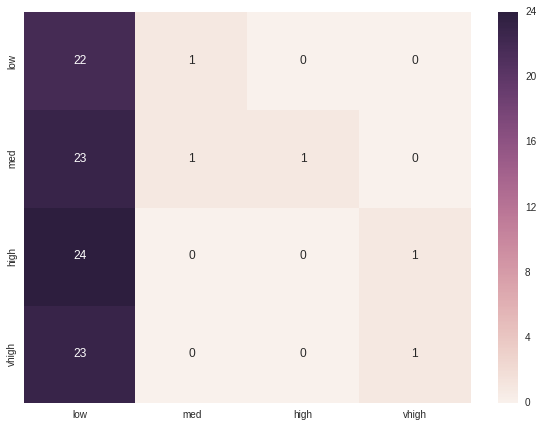

In [36]:
#Just with nnz >0:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(goodindices, \
                      [clf1.predict(i)[0] for i in balanced_samples[0] if csr_matrix(i).nnz>0], labels=np.array(["low", "med", "high", "vhigh"]))
0
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True, xticklabels=["low", "med", "high", "vhigh"], yticklabels=["low", "med", "high", "vhigh"])

In [37]:
clf1.score(np.array([i for i in balanced_samples[0] if csr_matrix(i).nnz>0]), goodindices)

0.24742268041237114

In [16]:
import os

In [17]:
def report_score_and_why(menuitem, vectorizer=vectorizer, model=clf1):
    input_vectorized = vectorizer.transform([tokenize_and_stem(menuitem)])
    if input_vectorized.nnz > 0:
        print(tokenize_and_stem(menuitem))
        print(input_vectorized.shape)
        #Need to change this to inputting model
        p = model.predict_proba(input_vectorized)[0]
        q = zip(model.classes_, list(p))
        classification = model.predict(input_vectorized)[0]
        probability = dict(q)[classification]
        # Figure out why: list individual score contribution of each word
        matchwords = [i for i in input_vectorized.todok().keys()] #todok = to dict of keys
        explaindict = {}
        ranklist = []
        for i in matchwords:
            w = vectorizer.get_feature_names()[i[1]] #gets actual word of feature, by matrix index
            coef = zip(model.classes_, model.coef_[:,i[1]])
            ranklist.append((w, dict(coef)["vhigh"]))
            explaindict[w] = dict(coef)
        # Figure out the biggest contributor:
        ranklist = sorted(ranklist, key=lambda a: a[1])
    else:
        classification = "unknown"
        probability = 0
        explaindict = {"unscorable": "yes"}
        ranklist = ["unscorable", "unscorable"]
        
    return classification, probability, explaindict, ranklist[-1][0]

NameError: name 'vectorizer' is not defined

In [18]:
report_score_and_why("Mussels")

NameError: name 'report_score_and_why' is not defined